# Testing the low-risk anomaly in Indian Equities using Decile Portfolios
Every quarter, we construct 10 portfolios in the following way:
using the market-cap mapping, we get the top 1100 stock by market cap for that quarter.
we then sort these by volatility and split them into 10 portfolios by increasing order of volatility. 
We simulate the returns generated by these decile portfolios and examine if the returns increase monotonically for increase in volatility in the portfolios 

# Import packages and load data 

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

#Load data
market_cap_mapping_path = 'clean data/quarterly market cap mapping.xlsx'
momentum_path = 'clean data/quarterly momentum.xlsx'
net_payout_yield_path = 'clean data/quarterly net payout yield.xlsx'
price_path = 'clean data/quarterly price.xlsx'
volatility_path = 'clean data/quarterly volatility.xlsx'

mcap_map = pd.read_excel(market_cap_mapping_path)
momentum = pd.read_excel(momentum_path)
npy = pd.read_excel(net_payout_yield_path)
price = pd.read_excel(price_path)
volatility = pd.read_excel(volatility_path)
outstanding_shares = pd.read_excel('clean data/quarterly outstanding shares.xlsx')

price.set_index('quarter', inplace=True)
momentum.set_index('quarter', inplace=True)
npy.set_index('quarter', inplace=True)
volatility.set_index('quarter', inplace=True)
outstanding_shares.set_index('quarter',inplace = True)

mcap_map.set_index('quarter',inplace = True)
mcapmap = mcap_map
mcapmap = pd.DataFrame(mcap_map.apply(lambda row: row.dropna().tolist(), axis=1))
mcapmap.columns = mcapmap.columns.map(str)
mcapmap.rename(columns={'0': 'top1100'}, inplace=True)


# Define functions required

In [23]:
# function to compute returns of an equal weight portfolio
def calculate_ew_returns(portfolio, prices_start, prices_end):
    start_prices = prices_start[portfolio]
    end_prices = prices_end[portfolio]
    returns = (end_prices / start_prices).mean() - 1
    return returns

# function to compute annualized returns 
def calculate_cagr(returns, periods_per_year=4):
    total_return = (1 + returns).prod()
    n_periods = len(returns)
    return total_return ** (periods_per_year / n_periods) - 1

# function to compute volatility
def calculate_volatility(returns, periods_per_year=4):
    return returns.std() * (periods_per_year ** 0.5)

# Simulate the decile portfolios and compute quarterly returns 

In [24]:
decile_returns_df = pd.DataFrame(index=mcapmap.index, columns=[f"Decile_{i + 1}" for i in range(10)])

for quarter in mcapmap.index:
    # Get stock list for the quarter
    stocks = mcapmap.loc[quarter].dropna().values[0]

    # Filter stocks with available volatility data for the specific quarter
    stocks_with_volatility = [s for s in stocks if not pd.isna(volatility.loc[quarter, s])]
    vol_data = volatility.loc[quarter, stocks_with_volatility].dropna()

    # Sort stocks by volatility (ascending order)
    vol_sorted_stocks = vol_data.sort_values().index.tolist()

    # Divide into 10 deciles
    decile_size = len(vol_sorted_stocks) // 10
    decile_portfolios = {
        f"Decile_{i + 1}": vol_sorted_stocks[i * decile_size : (i + 1) * decile_size]
        for i in range(10)
    }

    # Handle remainder 
    remainder = len(vol_sorted_stocks) % 10
    if remainder > 0:
        decile_portfolios[f"Decile_10"].extend(vol_sorted_stocks[-remainder:])

    # Calculate returns for each decile portfolio
    if quarter != mcapmap.index[-1]: 
        next_quarter = mcapmap.index[mcapmap.index.get_loc(quarter) + 1]

        for decile, portfolio in decile_portfolios.items():
            if len(portfolio) > 0:
                decile_returns = calculate_ew_returns(
                    portfolio, price.loc[quarter], price.loc[next_quarter]
                )
                decile_returns_df.loc[quarter, decile] = decile_returns
            else:
                decile_returns_df.loc[quarter, decile] = 0

decile_returns_df = decile_returns_df.astype(float)


decile_returns_df

,Decile_1,Decile_2,Decile_3,Decile_4,Decile_5,Decile_6,Decile_7,Decile_8,Decile_9,Decile_10
quarter,,,,,,,,,,
2005-01-01,0.130249,0.217482,0.250135,0.316070,0.313902,0.291501,0.337406,0.357146,0.398249,0.425478
2005-04-01,0.154498,0.240697,0.229266,0.243193,0.241387,0.275470,0.360415,0.340292,0.496682,0.292638
2005-07-01,0.102471,0.090981,0.051814,0.036250,0.029332,-0.016932,-0.041534,0.091835,-0.160169,-0.233420
2005-10-01,0.427067,0.107025,0.138084,0.079306,0.031770,0.027791,0.080980,0.059961,-0.014992,0.001643
2006-01-01,-0.019525,-0.109156,-0.102315,-0.072107,-0.011374,-0.091646,-0.028718,-0.038151,-0.027999,-0.065878
...,...,...,...,...,...,...,...,...,...,...
2023-01-01,0.108988,0.155836,0.166391,0.213001,0.208104,0.233944,0.240072,0.240191,0.280482,0.211567
2023-04-01,0.088689,0.114093,0.161373,0.137770,0.153547,0.176533,0.197583,0.261141,0.261720,0.251424
2023-07-01,0.106658,0.096187,0.143081,0.151248,0.142208,0.170960,0.169574,0.143643,0.146533,0.177478


# Compute annualized returns and volatility of the decile portfolios

In [25]:
cagr_vol_df = pd.DataFrame(columns=["CAGR", "Volatility"], index=decile_returns_df.columns)

for decile in decile_returns_df.columns:
    returns = decile_returns_df[decile].dropna()
    cagr_vol_df.loc[decile, "CAGR"] = calculate_cagr(returns)
    cagr_vol_df.loc[decile, "Volatility"] = calculate_volatility(returns)

cagr_vol_df

,CAGR,Volatility
Decile_1,0.216637,0.213717
Decile_2,0.190152,0.261007
Decile_3,0.176423,0.314464
Decile_4,0.205596,0.340996
Decile_5,0.191127,0.361092
Decile_6,0.185436,0.37414
Decile_7,0.18351,0.41239
Decile_8,0.180784,0.43129
Decile_9,0.157902,0.460451
Decile_10,0.157702,0.538845


# Plot returns against volatility and fit with a polynomial line

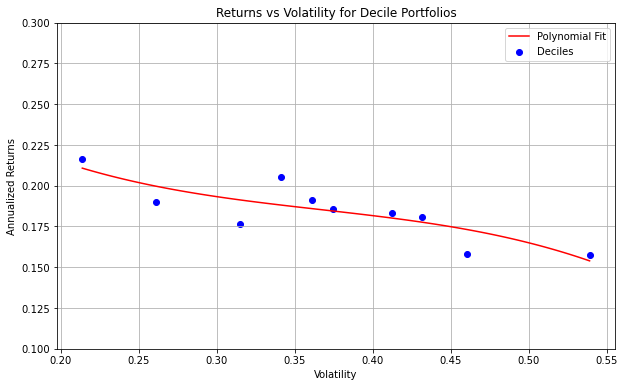

In [26]:
cagr_vol_df = cagr_vol_df.astype(float)

plt.figure(figsize=(10, 6))
plt.scatter(cagr_vol_df["Volatility"], cagr_vol_df["CAGR"], label="Deciles", color="blue")

poly_coeffs = np.polyfit(cagr_vol_df["Volatility"], cagr_vol_df["CAGR"], deg=3)
poly_fit = np.poly1d(poly_coeffs)

gx = np.linspace(cagr_vol_df["Volatility"].min(), cagr_vol_df["Volatility"].max(), 100)
plt.plot(gx, poly_fit(gx), label="Polynomial Fit", color="red")

plt.xlabel("Volatility")
plt.ylabel("Annualized Returns")
plt.title("Returns vs Volatility for Decile Portfolios")
plt.legend()
plt.grid(True)
plt.ylim([0.1, 0.3])  
 
plt.show()
